In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


In [35]:
# Data transforms
transform = transforms.Compose([
transforms.Resize((224, 224)),  # Resize images to 224x224
transforms.ToTensor(),         # Convert images to PyTorch tensors
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [36]:
# Load training data
train_dir = '/kaggle/input/ants-bees/hymenoptera_data/train'
train_dataset = ImageFolder(root=train_dir, transform=transform)

In [37]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root location: /kaggle/input/ants-bees/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [38]:
# Load validation data
val_dir = '/kaggle/input/ants-bees/hymenoptera_data/val'
val_dataset = ImageFolder(root=val_dir, transform=transform)

In [39]:
# Calculate the sizes of the validation and test sets
total_val_samples = len(val_dataset)
val_size = int(0.8 * total_val_samples)  # 80% for validation
test_size = total_val_samples - val_size  # Remaining 20% for test

In [40]:
# Split the validation dataset
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

In [41]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [43]:
# Define a function to display an image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [44]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

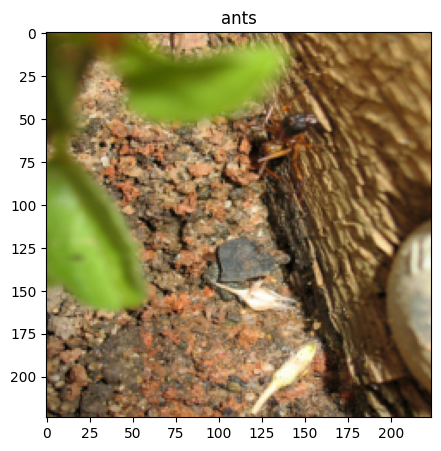

In [45]:
# Display the first image in the batch
index = 0
plt.figure(figsize=(5,5))
imshow(inputs[index], title=train_dataset.classes[classes[index]])
plt.show()

In [46]:
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

In [47]:
# Modify the final layer to match the number of classes (2 for ants and bees)
import torch.nn as nn
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [48]:
num_ftrs

512

In [49]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [50]:
import torch.optim as optim
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
import os

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [55]:
device

device(type='cuda')

In [56]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

In [57]:
print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 10/10, Loss: 0.029056424886221066


In [59]:
# Validation loop
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total:.2f}%')

Validation Loss: 0.7065943032503128, Accuracy: 81.97%


In [60]:
# Testing loop
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total:.2f}%')

Test Loss: 0.7562848329544067, Accuracy: 77.42%


In [63]:
# Save the model's state dictionary
model_save_path = 'model.h5'
torch.save(model.state_dict(), model_save_path)